In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import STL10
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
from utils import *
source_folder = 'source'

# Set seed
seed = 1
batch_size =  128
# Define mean and std from ImageNet data
in_mean = [0.485, 0.456, 0.406]
in_std = [0.229, 0.224, 0.225]

In [3]:
import litdata
from torch import nn
import torchvision.transforms as T
import torchvision.transforms.functional as F

class ToRGBTensor:
    
    def __call__(self, img):
        return F.to_tensor(img).expand(3, -1, -1) # Expand to 3 channels
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
#Loads in data and returns the dataloader

    
datapath = '/projects/ec232/data/'

# Define postprocessing / transform of data modalities
postprocess = (
    T.Compose([                        # Handles processing of the .jpg image
    ToRGBTensor(), 
    T.Resize((224,224), antialias=None),# Convert from PIL image to RGB torch.Tensor.
    T.Normalize(in_mean, in_std),  # Normalize image to correct mean/std.
]),
nn.Identity(), 
)

# Load training and validation data
traindata = litdata.LITDataset('ImageWoof', datapath).map_tuple(*postprocess)
valdata = litdata.LITDataset('ImageWoof', datapath, train=False).map_tuple(*postprocess)

# Make and return the dataloaders
train_dataloader = DataLoader(traindata, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(valdata, shuffle=False, batch_size=batch_size)



 

In [4]:
" Visualization of dataset"
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

In [10]:
from torchvision import transforms
from PIL import Image
image = images[0]
# # Convert the tensor to a PIL image
to_pil = transforms.ToPILImage()
pil_image = to_pil(image)

In [13]:
pil_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The number of classes in the dataset we want to finetune on
num_classes = 10

# Load ViT model with pretrained weighs
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=num_classes).to(device)


In [47]:
class CustomViTFeatureExtractor:
    
    def init(self, image_size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.image_size = image_size
        self.mean = mean
        self.std = std
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def call(self, image_path):
        # Load and preprocess the image
        #image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Add batch dimension
        image = image.unsqueeze(0)

        return image

torch.Size([1, 3, 224, 224])


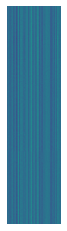

In [58]:
image_size=224
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])
image = transform(pil_image).unsqueeze(0)
print(image.shape)
modules = list(model.modules())

# Estrai i blocchi ViT (layers)
vit_blocks = [module for module in modules if 'Block' in str(type(module))]
# Example reshape (replace with actual values)
B = 1
N = 19
C = 3

# Reshape x to match (B, N, C)
image = image.view(1, -1,192)


tensor_image = vit_blocks[-2].attn(image)
min_val = tensor_image.min()
max_val = tensor_image.max()
tensor_image = (tensor_image - min_val) / (max_val - min_val)

# Converte il tensore in un'immagine PIL
image = Image.fromarray((tensor_image[0] * 255).byte().numpy())

# Mostra l'immagine
plt.imshow(np.squeeze(image))
plt.axis('off')
plt.show()

In [14]:
import torch
import torch.nn as nn
import timm

class CustomViT(nn.Module):
    def __init__(self, pretrained_model_name):
        super(CustomViT, self).__init__()
        # Carica il modello ViT preaddestrato
        self.model = timm.create_model(pretrained_model_name, pretrained=True)

    def prepare_tokens(self, x):
        # Esegui la preparazione dei token qui
        B, nc, w, h = x.shape
        x = self.model.patch_embed(x)  # patch linear embedding

        # Aggiungi il token [CLS] ai token dei patch incorporati
        cls_tokens = self.model.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Aggiungi la codifica posizionale a ciascun token
        #x = x + self.interpolate_pos_encoding(x, w, h)

        return self.model.pos_drop(x)

    def get_last_selfattention(self, x):
        # Ottieni l'ultimo livello di self-attention qui
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.model.blocks):
            if i < len(self.model.blocks) - 1:
                x = blk(x)
            else:
                # Restituisci l'attenzione dell'ultimo blocco
                attn_output = blk.attn(x)
                attentions = attn_output
    def forward(self, x):
        # Esegui un passaggio in avanti utilizzando il modello preaddestrato
        return self.model(x)




In [15]:


import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models


from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

def get_attention_map(img, get_mask=False):
    x = transform(img)
    x.size()
    

    att_mat = model(x.unsqueeze(0))
       
    print(att_mat.shape) 


    

 

    return attention_maps


result1 = get_attention_map(pil_image, get_mask=True)


torch.Size([1, 10])


NameError: name 'attention_maps' is not defined

In [72]:
modules = list(model.modules())

# Estrai i blocchi ViT (layers)
vit_blocks = [module for module in modules if 'Block' in str(type(module))]


In [73]:
vit_blocks


[Block(
   (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
   (attn): Attention(
     (qkv): Linear(in_features=192, out_features=576, bias=True)
     (q_norm): Identity()
     (k_norm): Identity()
     (attn_drop): Dropout(p=0.0, inplace=False)
     (proj): Linear(in_features=192, out_features=192, bias=True)
     (proj_drop): Dropout(p=0.0, inplace=False)
   )
   (ls1): Identity()
   (drop_path1): Identity()
   (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
   (mlp): Mlp(
     (fc1): Linear(in_features=192, out_features=768, bias=True)
     (act): GELU(approximate='none')
     (drop1): Dropout(p=0.0, inplace=False)
     (norm): Identity()
     (fc2): Linear(in_features=768, out_features=192, bias=True)
     (drop2): Dropout(p=0.0, inplace=False)
   )
   (ls2): Identity()
   (drop_path2): Identity()
 ),
 Block(
   (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
   (attn): Attention(
     (qkv): Linear(in_features=192, out_features=576, bia

In [62]:
model = CustomViT('vit_tiny_patch16_224')
    
visualize_predict(model, pil_image, (224,224), 16, device)

TypeError: Compose.__call__() takes 2 positional arguments but 3 were given